In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

import pymc3 as pm

### Water example

In [2]:
n = 9
x = 6

In [3]:
with pm.Model() as normal_aproximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=n, p=p, observed=x)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]

mean_q['p'], std_q

(array(0.66666667), array([0.15713484]))

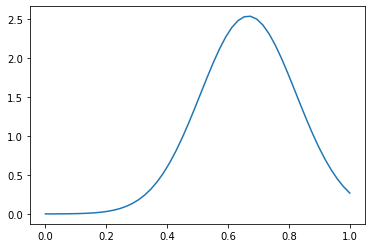

In [4]:
theta_grid = np.linspace(0,1)
posterior_quadratic_approx = norm.pdf(theta_grid, mean_q['p'], std_q)
plt.plot(theta_grid, posterior_quadratic_approx)

### Height example

In [6]:
dat = pd.read_csv('Howell1.csv', sep=';')

# We are interested in adult's height
dat_adults = dat[dat['age'] >= 18]

In [6]:
with pm.Model() as normal_aproximation:
    mu       = pm.Normal('mu', mu=170, sd=10)
    sigma    = pm.Uniform('sigma', lower=0, upper=33)
    height   = pm.Normal('height', mu=mu, sd=sigma, observed=dat_adults['height'])
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[mu, sigma])

In [7]:
st_dev = np.linalg.inv(hessian)**0.5

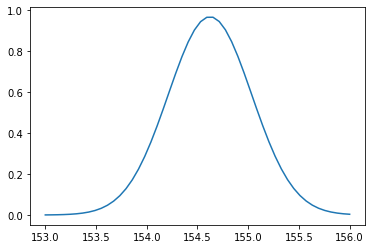

In [8]:
mu_grid = np.linspace(153,156)
posterior_quadratic_approx = norm.pdf(mu_grid, par_post['mu'], st_dev[0][0])
plt.plot(mu_grid, posterior_quadratic_approx)

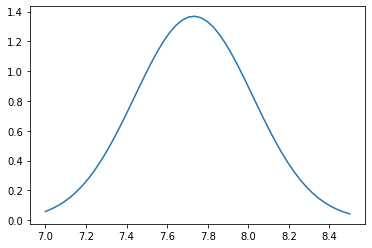

In [9]:
sigma_grid = np.linspace(7,8.5)
posterior_quadratic_approx = norm.pdf(sigma_grid, par_post['sigma'], st_dev[1][1])
plt.plot(sigma_grid, posterior_quadratic_approx)

### Regression for adults' weights

In [10]:
with pm.Model() as normal_aproximation:
    alpha    = pm.Normal('alpha', mu=170, sd=10)
    beta     = pm.Lognormal('beta', mu=0, sigma=1)
    sigma    = pm.Uniform('sigma', lower=0, upper=33)
    height   = pm.Normal('height',
                         mu=alpha + beta*(dat_adults['weight']-dat_adults['weight'].mean()),
                         sd=sigma, observed=dat_adults['height'])
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])

In [11]:
st_dev = np.linalg.inv(hessian)**0.5

/tmp/ipykernel_3227/2190977870.py:1: RuntimeWarning: invalid value encountered in sqrt
  st_dev = np.linalg.inv(hessian)**0.5


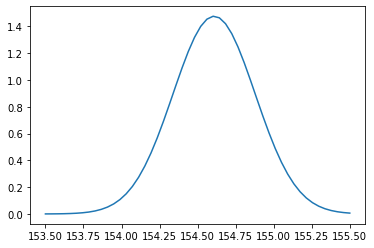

In [12]:
alpha_grid = np.linspace(153.5,155.5)
posterior_quadratic_approx = norm.pdf(alpha_grid, par_post['alpha'], st_dev[0][0])
plt.plot(alpha_grid, posterior_quadratic_approx)

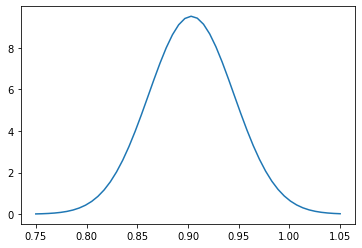

In [13]:
beta_grid = np.linspace(0.75, 1.05)
posterior_quadratic_approx = norm.pdf(beta_grid, par_post['beta'], st_dev[1][1])
plt.plot(beta_grid, posterior_quadratic_approx)

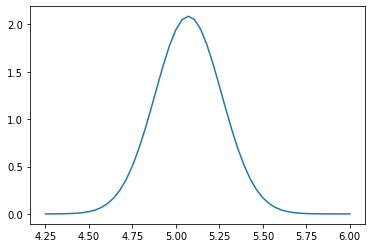

In [14]:
sigma_grid = np.linspace(4.25, 6)
posterior_quadratic_approx = norm.pdf(sigma_grid, par_post['sigma'], st_dev[2][2])
plt.plot(sigma_grid, posterior_quadratic_approx)

### Regression for all population

<AxesSubplot:xlabel='weight', ylabel='height'>

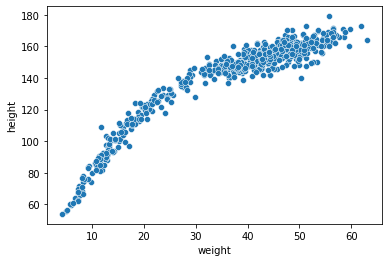

In [7]:
sns.scatterplot(data=dat, x='weight', y='height')

#plt.savefig('all_weights_all_heights', transparent=True)

In [8]:
dat_weight_s = (dat['weight']-dat['weight'].mean())/dat['weight'].std()

In [9]:
with pm.Model() as normal_aproximation:
    alpha    = pm.Normal('alpha', mu=170, sd=10)
    beta     = pm.Lognormal('beta', mu=0, sigma=1)
    sigma    = pm.Uniform('sigma', lower=0, upper=50)
    height   = pm.Normal('height',
                         mu=alpha + beta * dat_weight_s,
                         sd=sigma, observed=dat['height'])
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])

In [10]:
st_dev = np.linalg.inv(hessian)**0.5

/tmp/ipykernel_5113/2190977870.py:1: RuntimeWarning: invalid value encountered in sqrt
  st_dev = np.linalg.inv(hessian)**0.5


### Estimating confidence intervals

In [13]:
x_min      = dat['weight'].min()
x_max      = dat['weight'].max()
weight_seq = np.linspace(x_min, x_max)

In [14]:
sample_alpha = norm.rvs(size=10**4, loc=par_post['alpha'], scale=st_dev[0][0])
sample_beta  = norm.rvs(size=10**4, loc=par_post['beta'],  scale=st_dev[1][1])
sample_sigma = norm.rvs(size=10**4, loc=par_post['sigma'], scale=st_dev[2][2])

In [15]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(sample_alpha+sample_beta*(x_min-dat['weight'].mean())/dat['weight'].std(), [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [16]:
for i in range(1, len(weight_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile(sample_alpha+sample_beta*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std(),
                         [0.025, 0.975]).reshape(1,2),
             columns=['LCI', 'UCI'])
          ])

In [17]:
ConfidenceIntervals['weight'] = weight_seq

### Estimating prediction intervals

In [18]:
height_samp = norm.rvs(size=10**4,
             loc=sample_alpha+sample_beta*(x_min-dat['weight'].mean())/dat['weight'].std(),
             scale=sample_sigma)

PredictionIntervals = pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])

In [19]:
for i in range(1, len(weight_seq)):
    height_samp = norm.rvs(size=10**4,
             loc=sample_alpha+sample_beta*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std(),
             scale=sample_sigma)
    
    PredictionIntervals = pd.concat([PredictionIntervals,
                                     pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])])

In [20]:
PredictionIntervals['weight'] = weight_seq

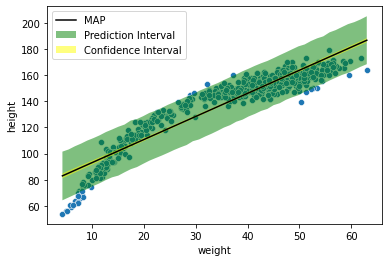

In [21]:
sns.scatterplot(data=dat, x='weight', y='height')

plt.plot([x_min, x_max],
         [par_post['alpha']+par_post['beta']*(x_min-dat['weight'].mean())/dat['weight'].std(),
          par_post['alpha']+par_post['beta']*(x_max-dat['weight'].mean())/dat['weight'].std()], color='k', label='MAP')

plt.fill_between(PredictionIntervals['weight'], PredictionIntervals['LPI'], PredictionIntervals['UPI'],
                 facecolor='green', alpha=0.5, label='Prediction Interval')

plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')
plt.legend()
#plt.savefig('reg_lineal_all.png', transparent=True)

### Regression for all population considering a quadratic polynomial

In [22]:
with pm.Model() as normal_aproximation:
    alpha    = pm.Normal('alpha', mu=170, sd=10)
    beta1    = pm.Lognormal('beta1', mu=0, sigma=1)
    beta2    = pm.Normal('beta2', mu=0, sd=1)
    sigma    = pm.Uniform('sigma', lower=0, upper=50)
    height   = pm.Normal('height',
                         mu=alpha + beta1*dat_weight_s + beta2*dat_weight_s**2,
                         sd=sigma, observed=dat['height'])
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta1, beta2, sigma])

In [23]:
st_dev = np.linalg.inv(hessian)**0.5

/tmp/ipykernel_5113/2190977870.py:1: RuntimeWarning: invalid value encountered in sqrt
  st_dev = np.linalg.inv(hessian)**0.5


### Estimating regression function (MAP)

In [24]:
regression_map = []

for i in range(len(weight_seq)):
    regression_map.append(par_post['alpha'] + \
                         par_post['beta1']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std() + \
                         par_post['beta2']*((weight_seq[i]-dat['weight'].mean())/dat['weight'].std())**2)

RegressionMAP = pd.DataFrame(regression_map, columns=['regression'])
RegressionMAP['weight'] = weight_seq

### Estimating confidence intervals

In [25]:
sample_alpha = norm.rvs(size=10**4, loc=par_post['alpha'], scale=st_dev[0][0])
sample_beta1 = norm.rvs(size=10**4, loc=par_post['beta1'], scale=st_dev[1][1])
sample_beta2 = norm.rvs(size=10**4, loc=par_post['beta2'], scale=st_dev[2][2])
sample_sigma = norm.rvs(size=10**4, loc=par_post['sigma'], scale=st_dev[3][3])

In [26]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(sample_alpha + \
                sample_beta1*(x_min-dat['weight'].mean())/dat['weight'].std() + \
                sample_beta2*((x_min-dat['weight'].mean())/dat['weight'].std())**2, [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [27]:
for i in range(1, len(weight_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile(sample_alpha + \
                         sample_beta1*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std() + \
                         sample_beta2*((weight_seq[i]-dat['weight'].mean())/dat['weight'].std())**2,
                         [0.025, 0.975]).reshape(1,2),
             columns=['LCI', 'UCI'])
          ])

In [28]:
ConfidenceIntervals['weight'] = weight_seq

### Estimating prediction intervals

In [29]:
height_samp = norm.rvs(size=10**4,
             loc=sample_alpha + \
                       sample_beta1*(x_min-dat['weight'].mean())/dat['weight'].std() + \
                       sample_beta2*((x_min-dat['weight'].mean())/dat['weight'].std())**2,
             scale=sample_sigma)

PredictionIntervals = pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])

In [30]:
for i in range(1, len(weight_seq)):
    height_samp = norm.rvs(size=10**4,
             loc=sample_alpha + \
                           sample_beta1*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std() + \
                           sample_beta2*((weight_seq[i]-dat['weight'].mean())/dat['weight'].std())**2,
             scale=sample_sigma)
    
    PredictionIntervals = pd.concat([PredictionIntervals,
                                     pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])])

In [31]:
PredictionIntervals['weight'] = weight_seq

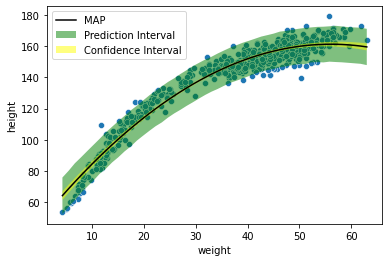

In [32]:
sns.scatterplot(data=dat, x='weight', y='height')

plt.plot(RegressionMAP['weight'], RegressionMAP['regression'], color='k', label='MAP')

plt.fill_between(PredictionIntervals['weight'], PredictionIntervals['LPI'], PredictionIntervals['UPI'],
                 facecolor='green', alpha=0.5, label='Prediction Interval')

plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')
plt.legend()
#plt.savefig('reg_quadratic_all.png', transparent=True)